<a href="https://colab.research.google.com/github/sgonzalezsilot/Newtral-Toxicity-Detection/blob/main/Newtral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entrevista técnica: Detección de toxicidad usando datos de Newtral
## Santiago González Silot
### @:sgonzalezsilot@gmail.com

## Instalación de paquetes

In [1]:
!pip install transformers
!pip install tweet-preprocessor
!pip install unidecode
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 6.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 11.8 MB/s eta 0:00:00


## Preprocesamiento y análisis exploratorio de los datos

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import pickle
import torch
import preprocessor as p
import unidecode
from tqdm import tqdm
import tensorflow as tf
import numpy as np
import shap
import scipy as sp

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

def comprobarGPU():
  if torch.cuda.is_available():    

      # Tell PyTorch to use the GPU.    
      device = torch.device("cuda")

      print('There are %d GPU(s) available.' % torch.cuda.device_count())

      print('We will use the GPU:', torch.cuda.get_device_name(0))

  # If not...
  else:
      print('No GPU available, using the CPU instead.')
      device = torch.device("cpu")

comprobarGPU()

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [5]:
df_train = pd.read_csv("/content/drive/MyDrive/Newtral/toxicity_train_data.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Newtral/toxicity_test_data.csv")

In [6]:
df_train

id  \
0      https://www.elplural.com/politica/espana/polem...   
1                                  1.271010900259078e+18   
2                                 1.2986035925013957e+18   
3                                 1.2811132626507776e+18   
4                                  1.465632198984405e+18   
...                                                  ...   
10995  https://www.newtral.es/default-rusia-suspensio...   
10996                             1.2322982404035502e+18   
10997  http://www.lavanguardia.com/opinion/20170507/4...   
10998  https://www.newtral.es/coronavirus-covid-casos...   
10999                             1.2801392403582484e+18   

                                                    text  label  \
0      Durante su intervención, el vicesecretario de ...      0   
1      Nueva manipulación a la mujer de la @rfef, dón...      1   
2      SOLIDARIDAD con los 500 trabajadores de Accion...      1   
3      ☀️ #BuenosDías #FelizJueves \n\n  Mañana nuest...      0   
4      Porros o educación gratuita.\n\nAdoctrinamient...      1   
...                                                  ...    ...   
10995  Rusia tiene los fondos para pagar sus deudas, ...      0   
10996   #Coronavirus Hoy mismo, #Madrid una reunión d...      0   
10997                       –No podemos decir la verdad.      0   
10998                                     [PANEL COVID |      0   
10999  Este maravilloso poema de Tere Irastortza (tra...      0   

              origin    id-type  
0      news-articles        url  
1            twitter  twitterId  
2            twitter  twitterId  
3            twitter  twitterId  
4            twitter  twitterId  
...              ...        ...  
10995  news-articles        url  
10996        twitter  twitterId  
10997  news-articles        url  
10998  news-articles        url  
10999        twitter  twitterId  

[11000 rows x 5 columns]

Para el preprocesamiento se van a eliminar URLs, menciones, hashtags, emojis y simbolos como ":) ". Ya que este tipo de símbolos nos son útiles para el modelo y pueden perjudicar su rendimiento.

Se usará la librería de expresiones regular en lugar de tweet-preprocessor ya que esta da problemas al trabajar con textos en español.

In [7]:
import re

def clean_text(text):
    # Expresiones regulares para eliminar URLs, menciones, hashtags, emojis y smileys
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    mention_pattern = re.compile(r'@\w+')
    hashtag_pattern = re.compile(r'#\w+')
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F1E0-\U0001F1FF"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    smiley_pattern = re.compile(r'(:\s?\)|:-\)|;\s?\)|:-\(|:D|:\'\()')

    # Eliminar URLs, menciones, hashtags, emojis y smileys
    cleaned_text = url_pattern.sub('', text)
    cleaned_text = mention_pattern.sub('', cleaned_text)
    cleaned_text = hashtag_pattern.sub('', cleaned_text)
    cleaned_text = emoji_pattern.sub('', cleaned_text)
    cleaned_text = smiley_pattern.sub('', cleaned_text)

    # Eliminar saltos de línea y espacios sobrantes
    cleaned_text = cleaned_text.strip().replace('\n', ' ').strip()

    return cleaned_text




# Limpiamos los tweets
for i in tqdm(range(df_train.shape[0])):
    # Limpiamos el tweet con tweet-preprocessor y lo pasamos a minúsculas
    df_train.loc[i, 'clean_text'] = clean_text(df_train.iloc[i]['text'])

for i in tqdm(range(df_test.shape[0])):
    # Limpiamos el tweet con tweet-preprocessor y lo pasamos a minúsculas
    df_test.loc[i, 'clean_text'] = clean_text(df_test.iloc[i]['text'])


train_texts = df_train.clean_text
train_labels = df_train.label
test_texts = df_test.clean_text
test_labels = df_train.label

100%|██████████| 5000/5000 [00:01<00:00, 4899.86it/s]


El dataset de entrenamiento consta de 11000 filas, provenientes de twitter y de artículos periodísticos

26.461

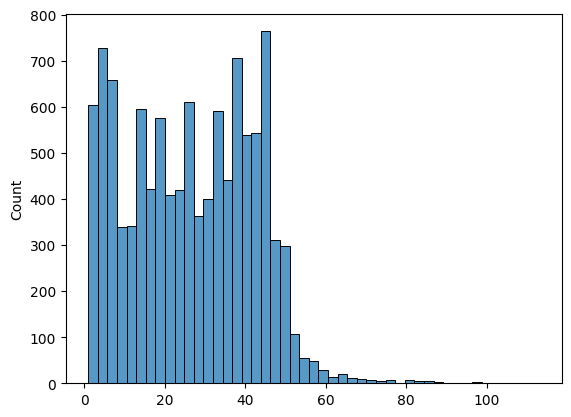

In [8]:
lengths_texts = [len(text.split()) for text in df_train["text"]]
sns.histplot(lengths_texts)
np.mean(lengths_texts)

In [9]:
print(df_train.iloc[0].text)
print(df_train.iloc[10].text)
print(df_train.iloc[100].text)

Durante su intervención, el vicesecretario de Vox también ha dejado patente la crisis a la que se enfrenta la derecha después de que Ciudadanos apoyase la pasada prórroga del estado de alarma, como se espera que también apoye la que se debate mañana.
Si eres de los que sale de paseo en plena cuarentena, te quiero bien lejos.
Si eres de los que aplauden los abusos policiales en plena cuarentena, te quiero igual de lejos.

Algún día esto terminará pero vuestra miseria seguirá estando ahí.
Saber comunicar en público es fundamental para las relaciones humanas y profesionales. Será un honor volver a la Liga Española de Debate Universitario, ahora como presidente del jurado, y poder evaluar y disfrutar el talento de los mejores oradores de la universidad nacional.   https://t.co/8b62nqQSrR


Como se puede observar, se tratan de textos bastante cortos, lo cual facilita el trabajo ya que los modelos de lenguaje como BERT/RoBERTa tienen un tamaño de entrada predefinido y de alrededor de 512 tokens (510 sin contar los 2 tokens predefinidos)


In [10]:
nltk.download('stopwords')

stops_es = set(stopwords.words("spanish"))

def makeClouds(df, idioma, colormap="viridis"):

  if idioma == "EN":
    stop = stops_en
    stop.add('http')
    stop.add('https')
    stop.add('co')
    stop.add('URL')
    stop.add('url')
  else:
    stop = stops_es
    stop.add('http')
    stop.add('https')
    stop.add('co')
    stop.add('URL')
    stop.add('url')
    stop.add("number")
    

  true_words = []
  for sentence in df:
    for word in sentence.split():
      true_words.append(word)

  true_words = ' '.join(true_words)

  cloud_true = WordCloud(stopwords = stop,background_color="white", max_words=400, width=500, height=500, colormap=colormap).generate(true_words)

  return cloud_true

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


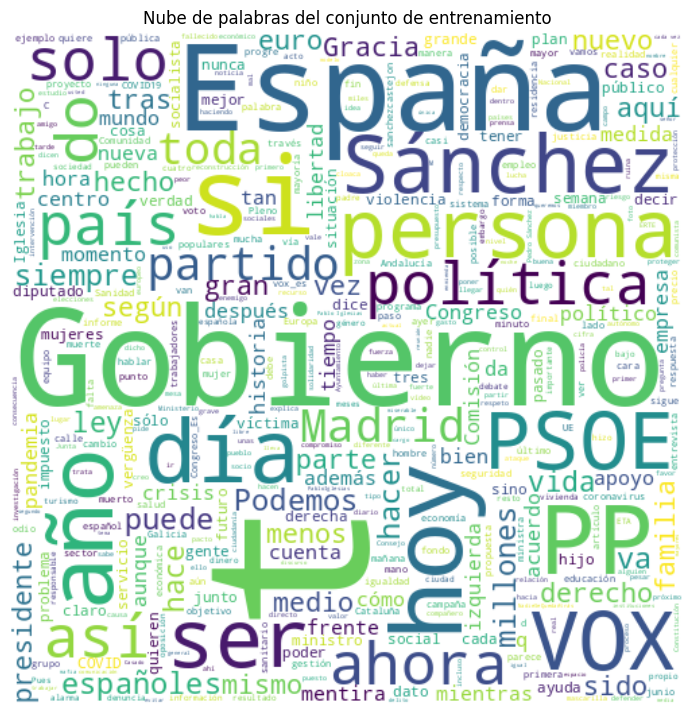

In [11]:
cloud = makeClouds(df_train.text,"ES")
plt.figure(figsize=(700/80,700/80))
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras del conjunto de entrenamiento")
plt.savefig("Wordcloud.png")

Como podemos observar en la nube de palabras, vemos que todas las palabras están muy relacionadas con la política español, vemos nombres de grandes partidos políticos de españa, y palabras de la temática (ley, congreso, etc). Además también se ven algunos de los temas a los que suelen recurrir los partidos: familia, mentira, futuro, violencia, libertad, etc.

Otro dato curioso es que podemos ver como aparece la palabra COVID19, lo que significa que los datos están scrappeados durante o trás la pandemía, por lo que puede ser útil un modelo que conozca esta palabra.

Probemos ahora a separar entre las noticias tóxicas y las no tóxicas, a ver si vemos diferencias en la nube de palabras.

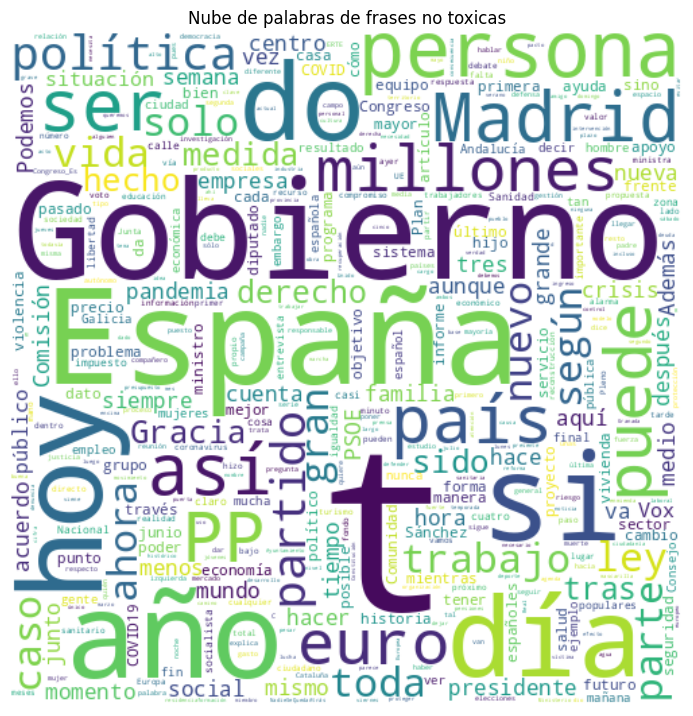

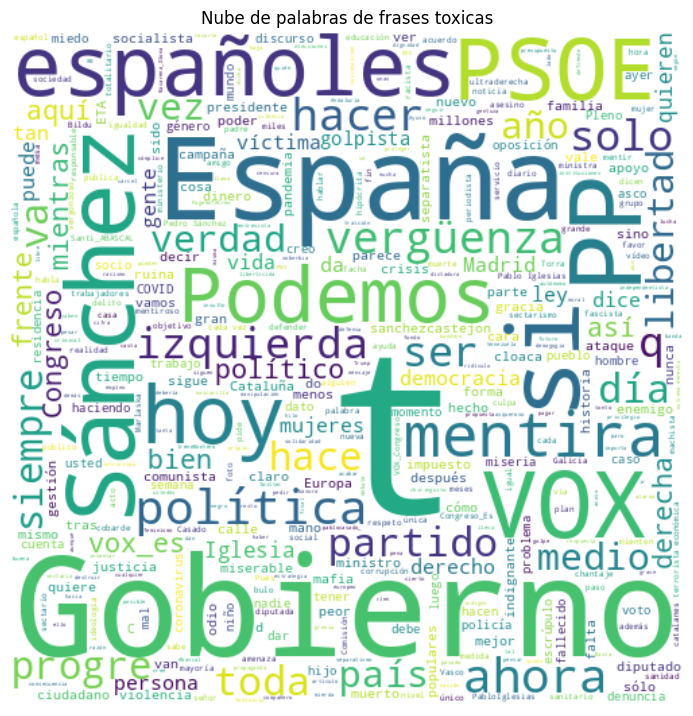

In [12]:
toxic = df_train.loc[df_train['label'] == 1].text
no_toxic = df_train.loc[df_train['label'] == 0].text

# toxic = preprocess(toxic.tweet, lowercase=True, python_tokenize=False, demojize=False, clean_hashtag=True, cardiff=False, remove_emojis=False)
# no_toxic = preprocess(no_toxic.tweet, lowercase=True, python_tokenize=False, demojize=False, clean_hashtag=True, cardiff=False, remove_emojis=False)


cloud = makeClouds(no_toxic, idioma="ES")
plt.figure(figsize=(700/80,700/80))
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras de frases no toxicas")
plt.savefig("Wordcloud.png")


cloud = makeClouds(toxic, idioma="ES")
plt.figure(figsize=(700/80,700/80))
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras de frases toxicas")
plt.savefig("Wordcloud.png")

En la nube de palabras podemos observar que en las frases tóxicas destacan bastante (el tamaño va en función de la relevancia) los nombres de los partidos políticos. Vemos como aparecen claramente: VOX, POSE, PP y PODEMOS, los principales partidos políticos. Tambien vemos el apellido del actual presidente: "Sanchez".

Además también vemos que algunas palabras presumiblemente tóxicas destacan bastante como pueden ser: mentira, verguenza, progre, miserable, etc.

En cambio en la nube de palabras de frases no tóxicas podemos ver que no se puede apreciar nada claramente. Simplemente aparecen palabras más relacionadas a la política y actualidad española.

In [13]:
def plot_top_ngrams_barchart(text, n=2, http=False, color="Greens_d", idioma="EN"):

    if idioma == "EN":
      stop = set(stopwords.words('english'))
    else:
      stop = set(stopwords.words('spanish'))
      stop.add("number")

    if http:
      stop.add('http')
      stop.add('https')
      stop.add('co')
      stop.add('URL')
      stop.add('url')



    # new = text.str.split()
    # new = new.values.tolist()
    corpus=[word for i in text for word in i]


    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n), stop_words=list(stop)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    pal = sns.color_palette(color, 10)
    fig = sns.barplot(x=y,y=x, palette=pal[::-1])
    return fig

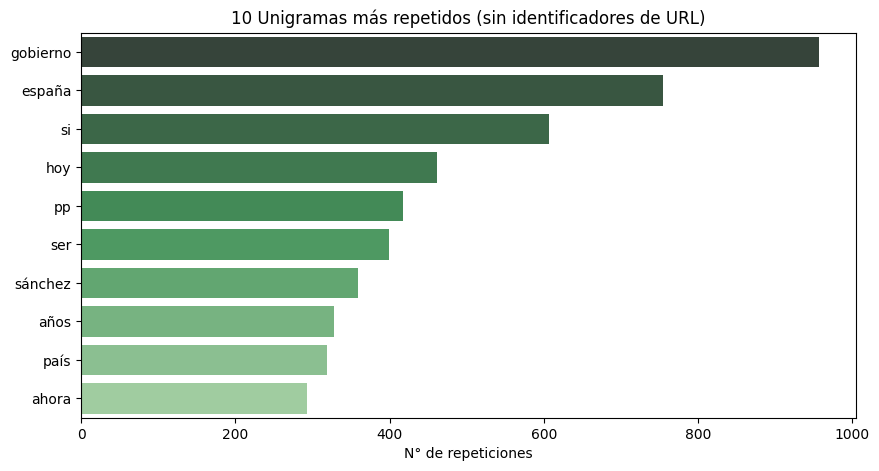

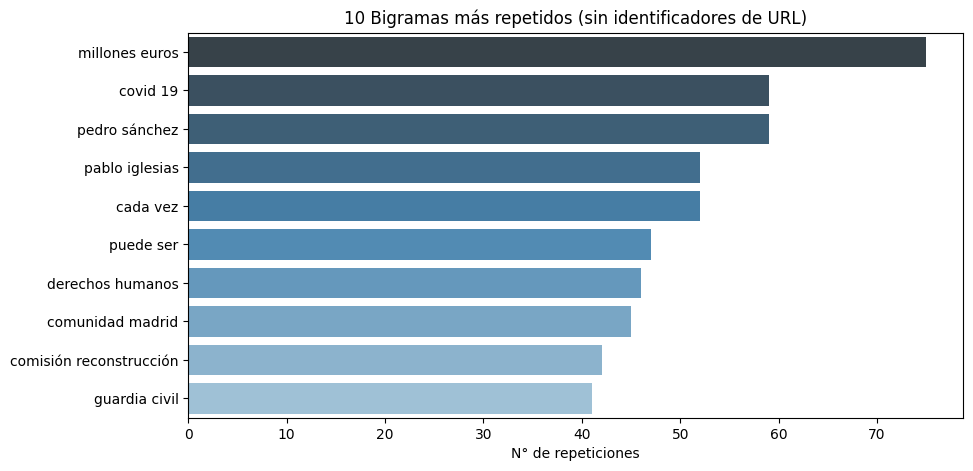

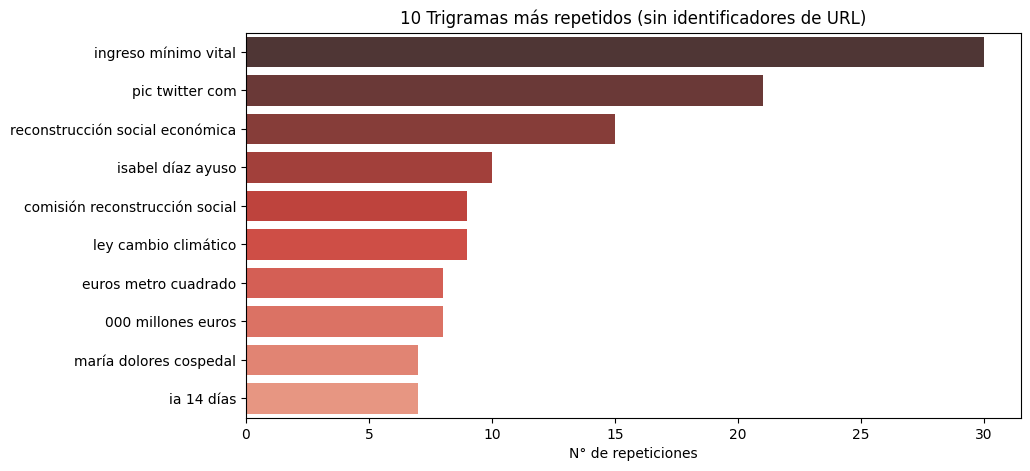

In [14]:
# Unigrams
plt.figure(figsize=(10,5))
fig1 = plot_top_ngrams_barchart(train_texts, n=1, http=True, color = "Greens_d", idioma="ES")
fig1.set_xlabel("N° de repeticiones")
fig1.set_title("10 Unigramas más repetidos (sin identificadores de URL)")
# plt.figure(figsize=(10,5))
# plt.show()
plt.savefig("Unigramas sin HTTP.png",bbox_inches='tight')

# Bigrams
plt.figure(figsize=(10,5))
fig2 = plot_top_ngrams_barchart(train_texts, n=2, http=True, color = "Blues_d", idioma="ES")
fig2.set_xlabel("N° de repeticiones")
fig2.set_title("10 Bigramas más repetidos (sin identificadores de URL)")
# plt.figure(figsize=(10,5))
# plt.show()
plt.savefig("Bigramas sin HTTP.png",bbox_inches='tight')

#Trigrams
plt.figure(figsize=(10,5))
fig3 = plot_top_ngrams_barchart(train_texts, n=3, http=True, color = "Reds_d", idioma="ES")
fig3.set_xlabel("N° de repeticiones")
fig3.set_title("10 Trigramas más repetidos (sin identificadores de URL)")
# plt.figure(figsize=(10,5))
# plt.show()
plt.savefig("Trigramas sin HTTP.png",bbox_inches='tight')

Este análisis de N-gramas nos permite conocer más sobre de que tratan los textos del dataset. Vemos que algunos de los bigramas que destacan son nombres de políticos: pedro sanchez o pablo iglesias. Temáticas como los derechos humanos, la comunidad de madrid o el covid 19.

Dentro de los trigramas podemos observar más tematicas como el ingreso minimo vital, el cambio climatico. Tambíen otra vez personajes públicos relevantes como isabel diaz ayudo y maria dolores cospedal.

También considero que resulta curioso el trigrama "cada vez más", a priori aparenta que precede a una crítica y/o queja de la situación actual. Por lo que es probable que este trigrama aparezca más en los textos tóxicos

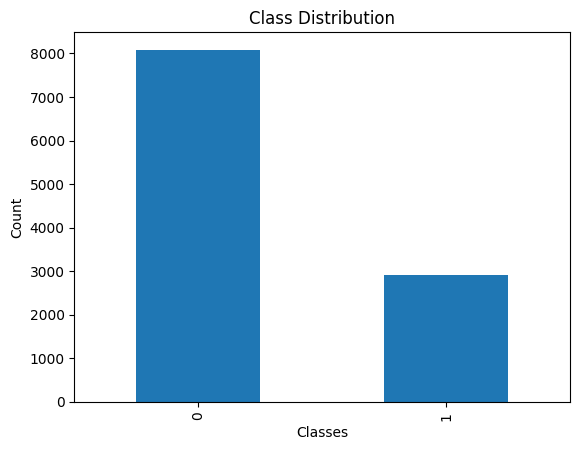

In [15]:
# Ver si está balanceado el dataset
class_distribution = df_train["label"].value_counts()
class_distribution.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

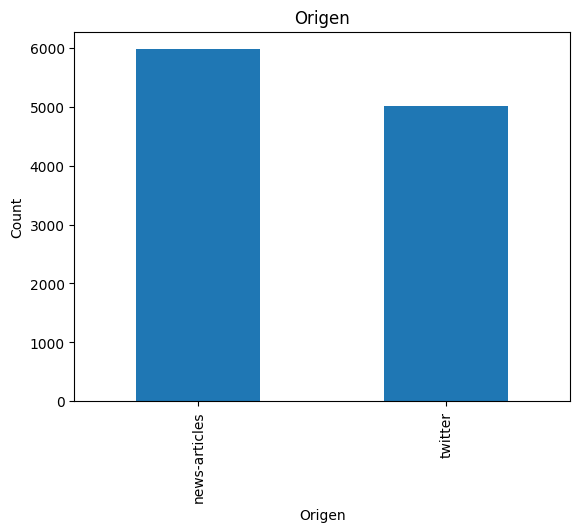

In [16]:
# Ver de donde proceden los textos
class_distribution = df_train["origin"].value_counts()
class_distribution.plot(kind='bar')
plt.xlabel('Origen')
plt.ylabel('Count')
plt.title('Origen')
plt.show()

## Modelos básicos (Baselines)

Si bien el estado del arte en clasificación en problemas de NLP lo marcan los modelos de lenguaje (especialmente los basados en transformers), como punto de partida para la resolución de un problema de este tipo, es una buena práctica empezar aplicando un enfoque de tf-idf + modelos "clásicos" de machine learning para así ver cual es el punto de partida y saber como mínimo que resultados deberían de obtener modelos más potentes como BERT o RoBERTa.



-------------      Linear SVC       -------------


The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


------------- Classification Report -------------
              precision    recall  f1-score   support

           0    0.93469   0.91690   0.92571      4308
           1    0.53747   0.60116   0.56753       692

    accuracy                        0.87320      5000
   macro avg    0.73608   0.75903   0.74662      5000
weighted avg    0.87971   0.87320   0.87614      5000



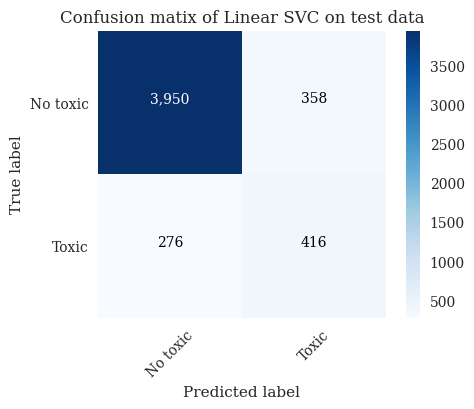



-------------      Logistic Regression       -------------


The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


------------- Classification Report -------------
              precision    recall  f1-score   support

           0    0.91299   0.94266   0.92759      4308
           1    0.55254   0.44075   0.49035       692

    accuracy                        0.87320      5000
   macro avg    0.73277   0.69171   0.70897      5000
weighted avg    0.86311   0.87320   0.86708      5000



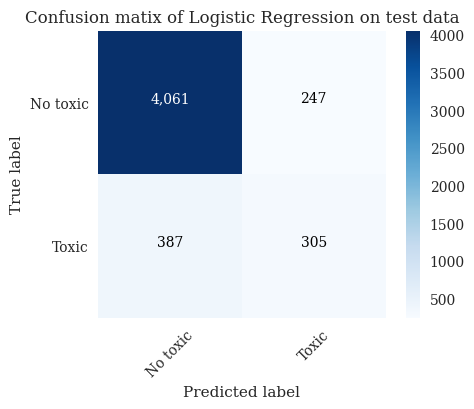



-------------      Decision Tree Classifier       -------------


The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


------------- Classification Report -------------
              precision    recall  f1-score   support

           0    0.88774   0.91968   0.90343      4308
           1    0.35568   0.27601   0.31082       692

    accuracy                        0.83060      5000
   macro avg    0.62171   0.59785   0.60713      5000
weighted avg    0.81411   0.83060   0.82141      5000



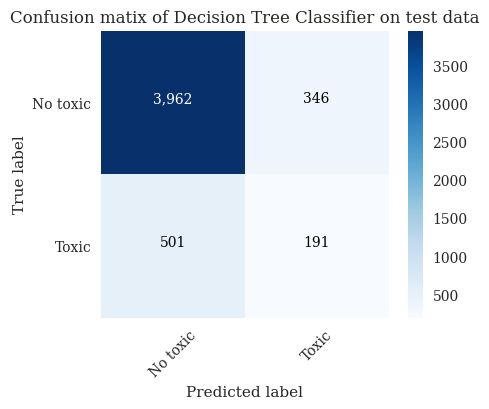



-------------      GradientBoost Classifier       -------------


The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


------------- Classification Report -------------
              precision    recall  f1-score   support

           0    0.89376   0.97052   0.93056      4308
           1    0.60559   0.28179   0.38462       692

    accuracy                        0.87520      5000
   macro avg    0.74967   0.62616   0.65759      5000
weighted avg    0.85388   0.87520   0.85500      5000



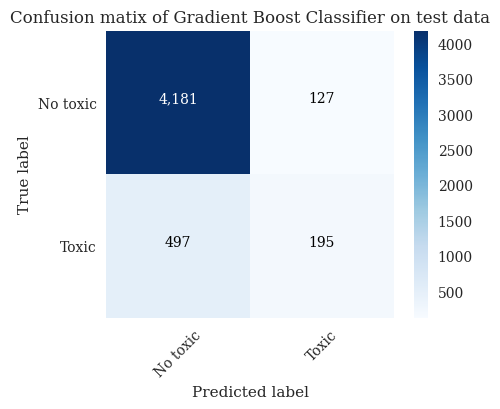

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import numpy as np
from sklearn.model_selection import cross_val_score
import itertools

def plot_confusion_matrixScikit(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.grid(False)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    #plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.xlabel('Predicted label')
    plt.show()

def getCompleteReportScikit(model, name,test_texts, digits=4):
  pred = model.predict(test_texts)
  pred = np.round(pred)
  pred = pred.flatten()

  # Use the seborn style
  plt.style.use('seaborn')
  
  # But with fonts from the document body
  plt.rcParams.update({
      "font.family": "serif"})
  

  print("------------- Classification Report -------------")
  print(classification_report(df_test['label'], pred, digits=5))
  plot_confusion_matrixScikit(confusion_matrix(df_test['label'],pred),target_names=['No toxic','Toxic'], normalize = False, \
                      title = f'Confusion matix of {name} on test data')
  
  return pred

def getCompleteReport(model, df_test, test_input_ids, test_attention_masks, digits=4):
  pred = model.predict([test_input_ids,test_attention_masks])
  # pred = np.round(pred)
  pred = np.argmax(pred, axis=1)
  pred = pred.flatten()
  print(pred)
  # Use the seborn style
  plt.style.use('seaborn')
  # But with fonts from the document body
  plt.rcParams.update({
      "font.family": "serif"})

  print("------------- Classification Report -------------")
  print(classification_report(df_test['label'], pred, digits=5))

  plot_confusion_matrixScikit(confusion_matrix(df_test['label'],pred),target_names=['No toxico','Toxico'], normalize = False, \
                      title = f'Confusion matix of {model.name} on test data')


print("\n")
print("-------------      Linear SVC       -------------")

pipeline = Pipeline([
      ('count', CountVectorizer()),  
      ('tfidf', TfidfTransformer()),  
      ('model', LinearSVC(random_state=0))
  ])
history = pipeline.fit(train_texts,train_labels)

pred = getCompleteReportScikit(pipeline, "Linear SVC",test_texts)

print("\n")
print("-------------      Logistic Regression       -------------")

pipeline = Pipeline([
      ('count', CountVectorizer()),  
      ('tfidf', TfidfTransformer()),  
      ('model', LogisticRegression(random_state=0))
  ])
history = pipeline.fit(train_texts,train_labels)

pred = getCompleteReportScikit(pipeline, "Logistic Regression",test_texts)

print("\n")
print("-------------      Decision Tree Classifier       -------------")

pipeline = Pipeline([
      ('count', CountVectorizer()),  
      ('tfidf', TfidfTransformer()),  
      ('model', DecisionTreeClassifier(random_state=0,max_depth=10))
  ])
history = pipeline.fit(train_texts,train_labels)

pred = getCompleteReportScikit(pipeline, "Decision Tree Classifier",test_texts)

# fig, ax = plt.subplots(figsize=(45,25))
# plot_tree(pipeline['model'], max_depth=10, ax = ax, fontsize=10, 
#           feature_names=pipeline['count'].get_feature_names(),
#           class_names=["true","fake"])


print("\n")
print("-------------      GradientBoost Classifier       -------------")

pipeline = Pipeline([
      ('count', CountVectorizer()),  
      ('tfidf', TfidfTransformer()),  
      ('model', GradientBoostingClassifier(random_state=0))
  ])
history = pipeline.fit(train_texts,train_labels)

pred = getCompleteReportScikit(pipeline, "Gradient Boost Classifier",test_texts)

En general los resultados obtenidos por estos clasificadores son sorpredenten buenos. Usando un enfoque más simple aportan buenos resultados usando mucha menos potencia de cómputo.

## Fine-Tuning

Para el proceso de fine-tuning se van a probar distintos enfoques:
* BERT XLM: Se usará un modelo de este tipo por 2  razones. En primer lugar para probar el rendimiento de un modelo independiente del dominio a la hora de resolver el problema. Por otro lado al ser un modelo cross-lingue creo que puede ser util ya que en este dataset hay algunos mensajes en catalán y quizá el uso de este modelo haga que se clasifiquen mejor esos mensajes.
* BERT de emociones: La hipotesis detrás de usar este modelo es que considero que hay una cierta relación entre el análisis de emociones y la toxicidad. Como para un proceso de fine-tuning se basa en usar un modelo que resuelva una tarea similar, considero que un modelo capaz de clasificar emociones es lo más parecido a un modelo de clasificación de toxicidad.
* Pre-training a un modelo de BERT con un conjunto de dato parecido + Fine-tuning

### Definición de funciones

A continuación se definen una serie de funciones para trabajar más comodamente con HuggingFace y Tensorflow para el entrenamiento de los modelos. Se ha decido trabajar con estas librerias en lugar de con PyTorch por comodidad al ya tener desarrollado código en estas librerias.

In [18]:
from transformers import AutoTokenizer, AutoModel, TFAutoModel,TFRobertaForSequenceClassification, TFBertModel, TFRobertaModel, AutoConfig
def getTokenizerAndModel(model_name, model_normalization=False, from_pt = False, regularization=False):
  tokenizer = AutoTokenizer.from_pretrained(model_name, normalization=model_normalization)
  configuration = AutoConfig.from_pretrained(model_name)
  if regularization == True:
    configuration.attention_probs_dropout_prob = 0.5
    configuration.hidden_dropout_prob = 0.2

  model = TFAutoModel.from_pretrained(model_name,from_pt=from_pt,config=configuration)

  return tokenizer, model


In [19]:
def bert_encode(tokenizer,data,maximum_length) :
  input_ids = []
  attention_masks = []
  

  for i in range(len(data)):
      encoded = tokenizer.encode_plus(   
        data[i],
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,
        truncation = True,
        return_attention_mask=True,
        # stride = 64
      )

      # print(encoded)
      
      input_ids.append(encoded['input_ids'])
      attention_masks.append(encoded['attention_mask'])

  return np.array(input_ids),np.array(attention_masks)

In [20]:
import matplotlib.pyplot as plt

def mostrarEvolucion(hist):

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()

In [21]:
def create_model_roberta(bert_model, model_name , lr, epsilon, optimizer,loss,sentence_length):
  input_ids = tf.keras.Input(shape=(sentence_length,),dtype='int32')
  attention_masks = tf.keras.Input(shape=(sentence_length,),dtype='int32')
  
  output = bert_model.roberta([input_ids,attention_masks])
  # print(output)
  # print(output[2])
  output = output[1]
  # output = tf.keras.layers.Dropout(0.5)(output)
 

  output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
  model = tf.keras.models.Model(name = model_name, inputs = [input_ids,attention_masks],outputs = output)

  model.compile(optimizer(learning_rate=lr,epsilon=epsilon), loss=loss, metrics=['accuracy'])
  return model

def create_model_bert(bert_model, model_name , lr, epsilon, optimizer,loss,sentence_length):
  input_ids = tf.keras.Input(shape=(sentence_length,),dtype='int32')
  attention_masks = tf.keras.Input(shape=(sentence_length,),dtype='int32')
  
  output = bert_model.bert([input_ids,attention_masks])
  # print(output)
  # print(output[2])
  output = output[1]
  # output = tf.keras.layers.Dropout(0.5)(output)
 

  output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
  model = tf.keras.models.Model(name = model_name, inputs = [input_ids,attention_masks],outputs = output)

  model.compile(optimizer(learning_rate=lr,epsilon=epsilon), loss=loss, metrics=['accuracy'])
  return model


def create_model_bertSHAP(bert_model, model_name , lr, epsilon, optimizer,loss,sentence_length):
  input_ids = tf.keras.Input(shape=(sentence_length,),dtype='int32')
  attention_masks = tf.keras.Input(shape=(sentence_length,),dtype='int32')
  
  output = bert_model.bert([input_ids,attention_masks])
  # print(output)
  # print(output[2])
  output = output[1]
  # output = tf.keras.layers.Dropout(0.5)(output)
 

  output = tf.keras.layers.Dense(2,activation='softmax')(output)
  model = tf.keras.models.Model(name = model_name, inputs = [input_ids,attention_masks],outputs = output)

  model.compile(optimizer(learning_rate=lr,epsilon=epsilon), loss=loss, metrics=['accuracy'])
  return model


def create_model_robertaSHAP(bert_model, model_name , lr, epsilon, optimizer,loss,sentence_length):
  input_ids = tf.keras.Input(shape=(sentence_length,),dtype='int32')
  attention_masks = tf.keras.Input(shape=(sentence_length,),dtype='int32')
  
  output = bert_model.roberta([input_ids,attention_masks])
  # print(output)
  # print(output[2])
  output = output[1]
  # output = tf.keras.layers.Dropout(0.5)(output)
 

  output = tf.keras.layers.Dense(2,activation='softmax')(output)
  model = tf.keras.models.Model(name = model_name, inputs = [input_ids,attention_masks],outputs = output)

  model.compile(optimizer(learning_rate=lr,epsilon=epsilon), loss=loss, metrics=['accuracy'])
  return model

In [22]:
def trainModel(model,train_input_ids,train_attention_masks, train_labels, validation_split, epochs, batch_size, callbacks):
  history = model.fit(x=[train_input_ids,train_attention_masks],
                      y=train_labels,
                      validation_split=validation_split, 
                      epochs=epochs,
                      batch_size=batch_size,
                      callbacks=callbacks)
  return history

### XLM


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFXLMRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.
The `pad_to_max_length` argument is deprecated and will b

Epoch 1/20
1100/1100 [==============================] - 358s 282ms/step - loss: 0.3202 - accuracy: 0.8675 - val_loss: 0.2242 - val_accuracy: 0.9091
Epoch 2/20
1100/1100 [==============================] - 264s 240ms/step - loss: 0.2017 - accuracy: 0.9251 - val_loss: 0.2005 - val_accuracy: 0.9241
Epoch 3/20
1100/1100 [==============================] - 262s 238ms/step - loss: 0.1331 - accuracy: 0.9525 - val_loss: 0.2693 - val_accuracy: 0.9195
Epoch 4/20
1100/1100 [==============================] - 261s 237ms/step - loss: 0.0937 - accuracy: 0.9665 - val_loss: 0.2726 - val_accuracy: 0.9168
Epoch 5/20
1100/1100 [==============================] - 266s 242ms/step - loss: 0.0724 - accuracy: 0.9741 - val_loss: 0.2632 - val_accuracy: 0.9255


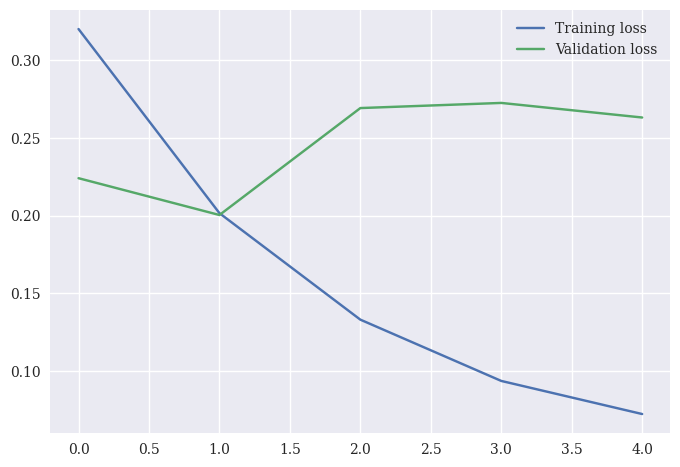

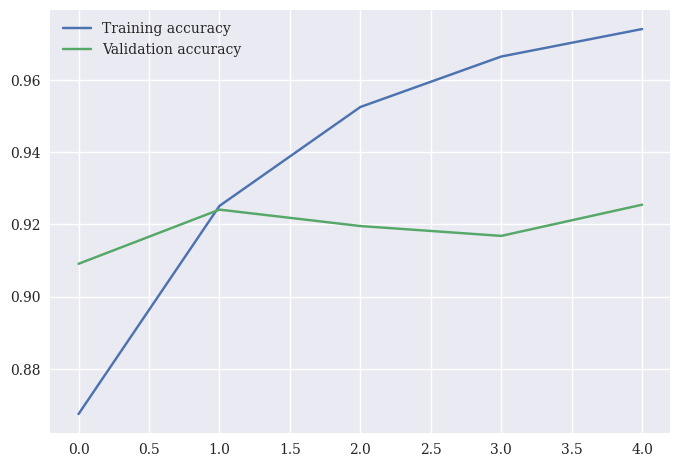

157/157 [==============================] - 39s 228ms/step
[0 0 0 ... 0 0 0]
------------- Classification Report -------------
              precision    recall  f1-score   support

           0    0.95932   0.91411   0.93617      4308
           1    0.58659   0.75867   0.66163       692

    accuracy                        0.89260      5000
   macro avg    0.77296   0.83639   0.79890      5000
weighted avg    0.90773   0.89260   0.89817      5000



The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


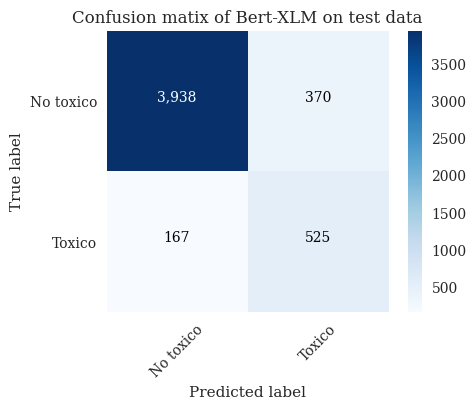

In [ ]:
option = "Entrenar modelo" #@param ["Entrenar modelo", "Descargar de Google Drive"]

if option == "Descargar de Google Drive":
  xlm = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/xlm-roberta-base-ES-finetuned.pkl","rb"))
  
  model_name = "xlm-roberta-base"
  tokenizer = AutoTokenizer.from_pretrained(model_name)

  test_texts = list(test_texts)
  test_encodings = tokenizer(test_texts, truncation=True, padding=True)

  sentence_length = 110
  test_input_ids,test_attention_masks = bert_encode(tokenizer,test_texts,sentence_length)
  getCompleteReport(xlm,df_test,test_input_ids, test_attention_masks)

elif option == "Entrenar modelo":
  tokenizer, xlm = getTokenizerAndModel("xlm-roberta-base", from_pt=True)

  optimizer = tf.keras.optimizers.Adam

  train_texts = list(train_texts)
  test_texts = list(test_texts)

  train_encodings = tokenizer(train_texts, truncation=True, padding=True)
  test_encodings = tokenizer(test_texts, truncation=True, padding=True)

  sentence_length = 110
  train_input_ids,train_attention_masks = bert_encode(tokenizer,train_texts,sentence_length)
  test_input_ids,test_attention_masks = bert_encode(tokenizer,test_texts,sentence_length)


  # Creo el modelo y congelo las capas ocultas
  model_name = "Bert-XLM"
  lr = 2e-5
  epsilon = 1e-8
  loss = "binary_crossentropy"

  xlm = create_model_robertaSHAP(xlm, model_name, lr, epsilon, optimizer, loss,sentence_length)
  # Saco una imagen
  tf.keras.utils.plot_model(xlm)
  # freezeLayers(model)

  train_labels_multiclass = tf.keras.utils.to_categorical(train_labels, num_classes=2)
  # Lo entreno
  early_stopping_monitor = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=1e-5, patience=3, restore_best_weights=True)
  history = trainModel(xlm,train_input_ids, train_attention_masks, train_labels_multiclass, validation_split=0.2, epochs=20, batch_size=8, callbacks=[early_stopping_monitor])

  # Obtengo métricas y gráficas
  mostrarEvolucion(history)
  guardarEnDrive = True #@param ["False", "True"] {type:"raw"}
  
  if guardarEnDrive:
    pickle.dump(xlm,open("/content/drive/MyDrive/Colab Notebooks/xlm-roberta-base-ES-finetuned.pkl","wb"))
  getCompleteReport(xlm,df_test,test_input_ids, test_attention_masks)

### Beto Emotion

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['bert.embeddings.position_ids', 'classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequenc

Epoch 1/20
1100/1100 [==============================] - 303s 235ms/step - loss: 0.2226 - accuracy: 0.9095 - val_loss: 0.1770 - val_accuracy: 0.9327
Epoch 2/20
1100/1100 [==============================] - 231s 210ms/step - loss: 0.0892 - accuracy: 0.9682 - val_loss: 0.2349 - val_accuracy: 0.9195
Epoch 3/20
1100/1100 [==============================] - 230s 209ms/step - loss: 0.0378 - accuracy: 0.9869 - val_loss: 0.2412 - val_accuracy: 0.9295
Epoch 4/20
1100/1100 [==============================] - 229s 208ms/step - loss: 0.0248 - accuracy: 0.9918 - val_loss: 0.2595 - val_accuracy: 0.9323


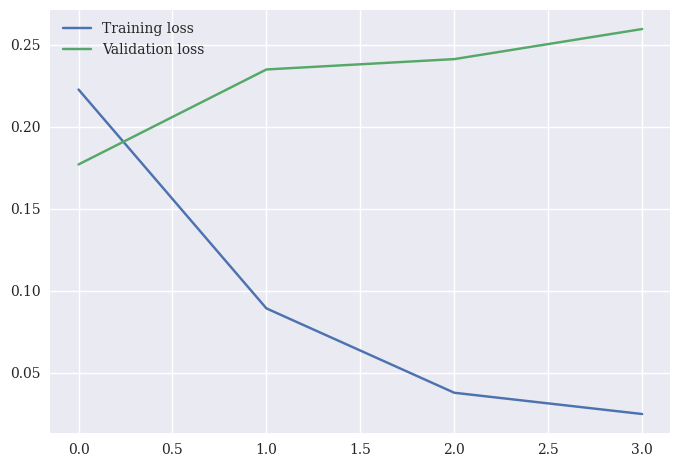

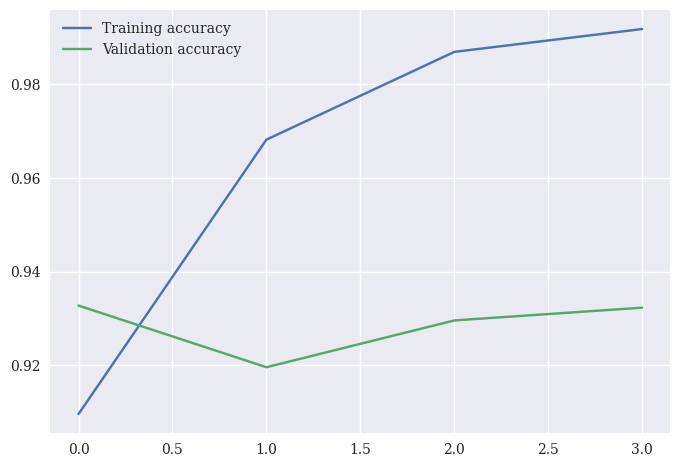

157/157 [==============================] - 42s 252ms/step
[0 0 0 ... 0 0 0]
------------- Classification Report -------------
              precision    recall  f1-score   support

           0    0.94574   0.94266   0.94420      4308
           1    0.65014   0.66329   0.65665       692

    accuracy                        0.90400      5000
   macro avg    0.79794   0.80298   0.80043      5000
weighted avg    0.90483   0.90400   0.90440      5000



The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


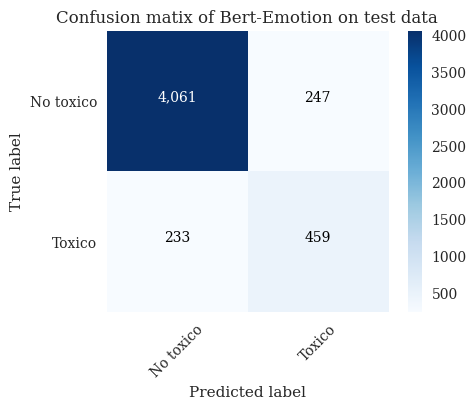

In [23]:
option = "Entrenar modelo" #@param ["Entrenar modelo", "Descargar de Google Drive"]

if option == "Descargar de Google Drive":
  beto_emotion = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/model_beto_emotion_finetune_toxic_ES.pkl","rb"))
  
  model_name = "finiteautomata/beto-emotion-analysis"
  tokenizer = AutoTokenizer.from_pretrained(model_name)

  test_texts = list(test_texts)
  test_encodings = tokenizer(test_texts, truncation=True, padding=True)

  sentence_length = 110
  test_input_ids,test_attention_masks = bert_encode(tokenizer,test_texts,sentence_length)
  getCompleteReport(beto_emotion,df_test,test_input_ids, test_attention_masks)

elif option == "Entrenar modelo":
  tokenizer, bert_model = getTokenizerAndModel("finiteautomata/beto-emotion-analysis", from_pt=True)

  optimizer = tf.keras.optimizers.Adam

  train_texts = list(train_texts)
  test_texts = list(test_texts)

  train_encodings = tokenizer(train_texts, truncation=True, padding=True)
  test_encodings = tokenizer(test_texts, truncation=True, padding=True)

  sentence_length = 110
  train_input_ids,train_attention_masks = bert_encode(tokenizer,train_texts,sentence_length)
  test_input_ids,test_attention_masks = bert_encode(tokenizer,test_texts,sentence_length)


  # Creo el modelo y congelo las capas ocultas
  model_name = "Bert-Emotion"
  lr = 2e-5
  epsilon = 1e-8
  loss = "binary_crossentropy"

  beto_emotion = create_model_bertSHAP(bert_model, model_name, lr, epsilon, optimizer, loss,sentence_length)
  # Saco una imagen
  tf.keras.utils.plot_model(beto_emotion)
  # freezeLayers(model)

  train_labels_multiclass = tf.keras.utils.to_categorical(train_labels, num_classes=2)
  # Lo entreno
  early_stopping_monitor = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=1e-5, patience=3, restore_best_weights=True)
  history = trainModel(beto_emotion,train_input_ids, train_attention_masks, train_labels_multiclass, validation_split=0.2, epochs=20, batch_size=8, callbacks=[early_stopping_monitor])

  # Obtengo métricas y gráficas
  mostrarEvolucion(history)
  guardarEnDrive = True #@param ["False", "True"] {type:"raw"}
  
  if guardarEnDrive:
    pickle.dump(beto_emotion,open("/content/drive/MyDrive/Colab Notebooks/model_beto_emotion_finetune_toxic_ES.pkl","wb"))
  getCompleteReport(beto_emotion,df_test,test_input_ids, test_attention_masks)

### Pre-training

Finalmente, ya que he encontrado un [conjunto de datos externos](https://www.kaggle.com/datasets/ricardomoya/tweets-poltica-espaa) de calidad de entorno a 250.000 tweets sobre política española, he decidido como última opción aplicar un proceso de pre-entrenamiento (aprendizaje no supervisado, Masked Language) con estos datos externos para posteriormente aplicar un fine-tuning con nuestros datos.

La idea detrás de esto es intentar que el modelo aprenda los conceptos, relaciones y contexto que hay detrás de este tipo de textos de política española, para que así posteriormente en la tarea de clasificación le sea más fácil.

Como modelo base para el pre-training he decidido usar el mismo modelo de Beto para detección de emociones, ya que recientemente en una [competición internacional de NLP de detección de la depresión](https://sites.google.com/view/mentalriskes) he aplicado este enfoque con este mismo modelo obtiendo muy buenos resultados.

Todo el proceso de entrenamiento se ha realizado en un notebook aparte que se encuentra disponible en el [repositorio de github](https://github.com/sgonzalezsilot/Newtral-Toxicity-Detection) o [aquí]()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing TFXLMRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Epoch 1/20
1100/1100 [==============================] - 346s 275ms/step - loss: 0.5033 - accuracy: 0.7577 - val_loss: 0.4519 - val_accuracy: 0.8050
Epoch 2/20
1100/1100 [==============================] - 265s 241ms/step - loss: 0.4178 - accuracy: 0.8167 - val_loss: 0.4064 - val_accuracy: 0.8223
Epoch 3/20
1100/1100 [==============================] - 266s 242ms/step - loss: 0.3576 - accuracy: 0.8503 - val_loss: 0.3873 - val_accuracy: 0.8427
Epoch 4/20
1100/1100 [==============================] - 266s 242ms/step - loss: 0.2910 - accuracy: 0.8843 - val_loss: 0.3738 - val_accuracy: 0.8514
Epoch 5/20
1100/1100 [==============================] - 267s 242ms/step - loss: 0.2322 - accuracy: 0.9133 - val_loss: 0.3533 - val_accuracy: 0.8477
Epoch 6/20
1100/1100 [==============================] - 261s 237ms/step - loss: 0.1839 - accuracy: 0.9342 - val_loss: 0.3683 - val_accuracy: 0.8605
Epoch 7/20
1100/1100 [==============================] - 264s 240ms/step - loss: 0.1448 - accuracy: 0.9494 - val_

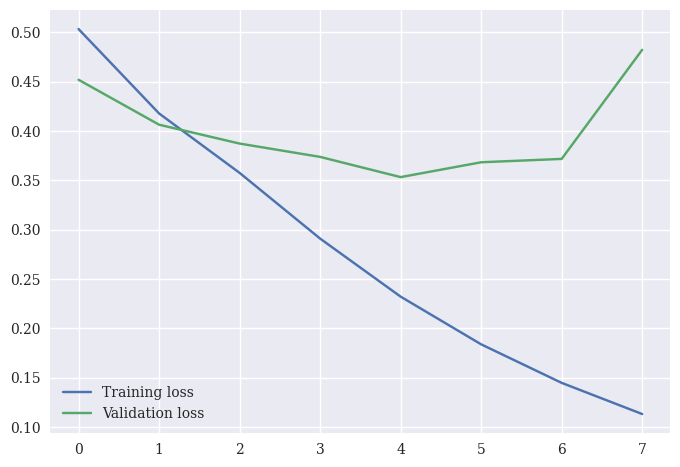

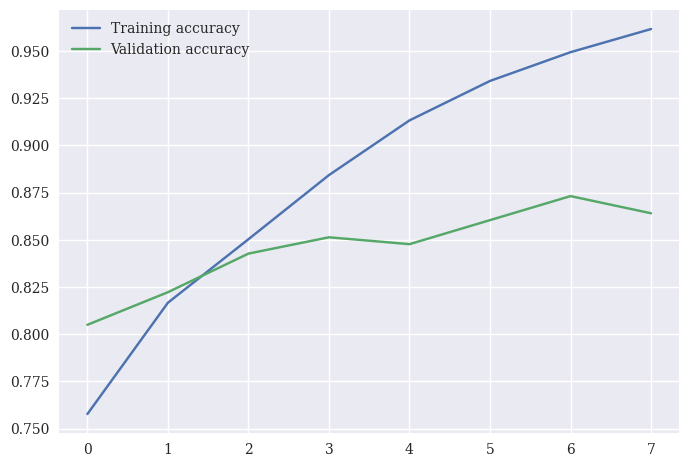

157/157 [==============================] - 39s 232ms/step
[0 0 0 ... 0 0 0]
------------- Classification Report -------------
              precision    recall  f1-score   support

           0    0.91780   0.92526   0.92151      4308
           1    0.50989   0.48410   0.49666       692

    accuracy                        0.86420      5000
   macro avg    0.71385   0.70468   0.70909      5000
weighted avg    0.86134   0.86420   0.86271      5000



The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


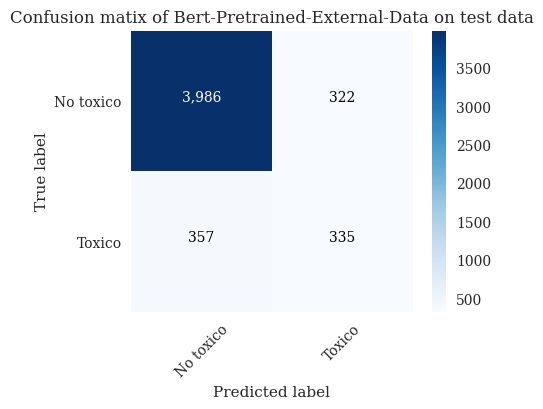

In [ ]:
option = "Entrenar modelo" #@param ["Entrenar modelo", "Descargar de Google Drive"]

if option == "Descargar de Google Drive":
  pretrained = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/beto-emotion-twitter-tweets-politica-ES-finetuned.pkl","rb"))
  
  model_name = "finiteautomata/beto-emotion-analysis"
  tokenizer = AutoTokenizer.from_pretrained(model_name)

  test_texts = list(test_texts)
  test_encodings = tokenizer(test_texts, truncation=True, padding=True)

  sentence_length = 110
  test_input_ids,test_attention_masks = bert_encode(tokenizer,test_texts,sentence_length)
  getCompleteReport(pretrained,df_test,test_input_ids, test_attention_masks)

elif option == "Entrenar modelo":
  # tokenizer, bert_model = getTokenizerAndModel("finiteautomata/beto-emotion-analysis", from_pt=True)

  model_name = "finiteautomata/beto-emotion-analysis"
  tokenizer = AutoTokenizer.from_pretrained(model_name)
  pretrained = TFAutoModel.from_pretrained("xlm-roberta-base",from_pt=True)

  optimizer = tf.keras.optimizers.Adam

  train_texts = list(train_texts)
  test_texts = list(test_texts)

  train_encodings = tokenizer(train_texts, truncation=True, padding=True)
  test_encodings = tokenizer(test_texts, truncation=True, padding=True)

  sentence_length = 110
  train_input_ids,train_attention_masks = bert_encode(tokenizer,train_texts,sentence_length)
  test_input_ids,test_attention_masks = bert_encode(tokenizer,test_texts,sentence_length)


  # Creo el modelo y congelo las capas ocultas
  model_name = "Bert-Pretrained-External-Data"
  lr = 2e-5
  epsilon = 1e-8
  loss = "binary_crossentropy"

  pretrained = create_model_robertaSHAP(pretrained, model_name, lr, epsilon, optimizer, loss,sentence_length)
  # Saco una imagen
  tf.keras.utils.plot_model(pretrained)
  # freezeLayers(model)

  train_labels_multiclass = tf.keras.utils.to_categorical(train_labels, num_classes=2)
  # Lo entreno
  early_stopping_monitor = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=1e-5, patience=3, restore_best_weights=True)
  history = trainModel(pretrained,train_input_ids, train_attention_masks, train_labels_multiclass, validation_split=0.2, epochs=20, batch_size=8, callbacks=[early_stopping_monitor])

  # Obtengo métricas y gráficas
  mostrarEvolucion(history)
  guardarEnDrive = True #@param ["False", "True"] {type:"raw"}
  
  if guardarEnDrive:
    pickle.dump(pretrained,open("/content/drive/MyDrive/Colab Notebooks/beto-emotion-twitter-tweets-politica-ES-finetuned.pkl","wb"))
  getCompleteReport(pretrained,df_test,test_input_ids, test_attention_masks)

### Elección del mejor modelo

Todos los modelos obtienen unas buenas métricas y relativamente similares entorno al 80/90% de f1-score (se usa esta métrica como referencia ya que es un conjunto de datos no balanceado). Finalmente se escoge como mejor modelo Beto Emotion (y será el usado para el resto del análisis).

Este modelo no solo aporte un mejor f1-score si no que además logra clasificar mejor la clase minoritaría, que es la que nos interesa, es decir, la clas tóxica.

## Análisis de errrores

In [ ]:
def getExcelErrores(model_name, pred):
  df_test_errores = df_test.copy()
  val_ori = df_test.copy()
  
  df_misclass = val_ori[pred!=df_test_errores['label']]

  # Inserto los tweets ya procesados
  indices = df_misclass.index
  test_texts_np = np.array(test_texts)

  # Genero el excel
  df_misclass.to_excel(f"Errores {model_name}.xlsx")

  return df_misclass

In [ ]:
df_errores = getExcelErrores(beto_emotion, pred)

In [ ]:
df_errores

id  \
14                                1.452528062264918e+18   
21                               1.3802771410366956e+18   
24                                1.346924631580676e+18   
35                                1.348675264239313e+18   
63                               1.4580547342464492e+18   
...                                                 ...   
4937  https://ctxt.es/es/20230301/Politica/42481/Gui...   
4946                             1.3605291317299937e+18   
4979                             1.3764781421567017e+18   
4982                             1.4537839997264282e+18   
4995                              1.451427698337849e+18   

                                                   text  label         origin  \
14    Pero ¿qué tienen que ocultar? ¿Por qué nunca c...      1        twitter   
21    Han convertido a TVE en una agencia de colocac...      1        twitter   
24    Los que aquí han alentado toda la conspiranoia...      1        twitter   
35    El paro en España. \n\n👇🏻 \n\nCausalidad...mmm...      1        twitter   
63    El Senado admite el término «países catalanes»...      1        twitter   
...                                                 ...    ...            ...   
4937  Sin la moción de 1980 no hubiera sido posible ...      1  news-articles   
4946  Para el Gobierno PSOE-Podemos la vida de polic...      1        twitter   
4979  Transfuguismo es corrupción.\n\n4.000€/mes de ...      1        twitter   
4982  La dercha siempre nos dice que lo hacemos fata...      0        twitter   
4995  Hoy me he levantado un poco más temprano para ...      0        twitter   

        id-type                                         clean_text  
14    twitterId  Pero ¿qué tienen que ocultar? ¿Por qué nunca c...  
21    twitterId  Han convertido a TVE en una agencia de colocac...  
24    twitterId  Los que aquí han alentado toda la conspiranoia...  
35    twitterId  El paro en España.  Causalidad...mmm ... NO.Ca...  
63    twitterId  El Senado admite el término «países catalanes»...  
...         ...                                                ...  
4937        url  Sin la moción de 1980 no hubiera sido posible ...  
4946  twitterId  Para el Gobierno PSOE-Podemos la vida de polic...  
4979  twitterId  Transfuguismo es corrupción.4.000€/mes de dine...  
4982  twitterId  La dercha siempre nos dice que lo hacemos fata...  
4995  twitterId  Hoy me he levantado un poco más temprano para ...  

[622 rows x 6 columns]

Como podemos observar, el modelo comete 644 errores en el conjunto de datos de test. Como hemos visto anteriormente con las matrices de confusión, el modelo falla más con los textos tóxicos. Esto es un problema ya que es la clase más importante a predecir. Intentemos ver si podemos ver algún patrón en los textos que falla el modelo.

In [ ]:
df_errores.sample(10)[["text","label", "clean_text"]]

text  label  \
1289  Yo aspiro a que me toque el euromillones... no...      1   
4933  25 de Junio de 2021. entra en vigor la Ley de ...      1   
1162  Dicen que se sienten amenazados\n\n¿Con media ...      1   
4135  Que el ministro del Interior llame criminal al...      1   
3931  @sanchezcastejon le da 53 millones € a la comp...      1   
3909  A esto siguió el cierre de la Comisión parlame...      1   
668   Sentir el dolor de los demás, un paso fundamen...      0   
3290  Será por sus “Caulidades” para ser “ídoneo”. L...      1   
3267  No está en peligro la democracia.\nNo está en ...      1   
2292  Normal la deriva de Cs..... No hay otra.  Comu...      1   

                                             clean_text  
1289  Yo aspiro a que me toque el euromillones... no...  
4933  25 de Junio de 2021. entra en vigor la Ley de ...  
1162  Dicen que se sienten amenazados¿Con media doce...  
4135  Que el ministro del Interior llame criminal al...  
3931  le da 53 millones € a la compañía aérea chavis...  
3909  A esto siguió el cierre de la Comisión parlame...  
668   Sentir el dolor de los demás, un paso fundamen...  
3290  Será por sus “Caulidades” para ser “ídoneo”. L...  
3267  No está en peligro la democracia.No está en pe...  
2292  Normal la deriva de Cs..... No hay otra.  Comu...

Como podemos observar, algunos de los tweets con los que el modelo falla se trata de ironía o sarcasmo, dos de los conceptos más difíciles de gestionar y detectar en problemas de NLP, ya que en estos el contexto es muy importante. Además otros de estos textos hacen referencia a otros textos (citados de twitter), por lo que probablemente el anotador haya podido detectar fácilmente que son textos tóxicos, pero al modelo al no tener todo el contexto necesario (tweet que cita e imagen) no puede llegar a discernir que se trata de un mensaje tóxico.

A cotninuacióm, veremos si el modelo clasifica mejor los textos de twitter o de los artículos periodísticos.

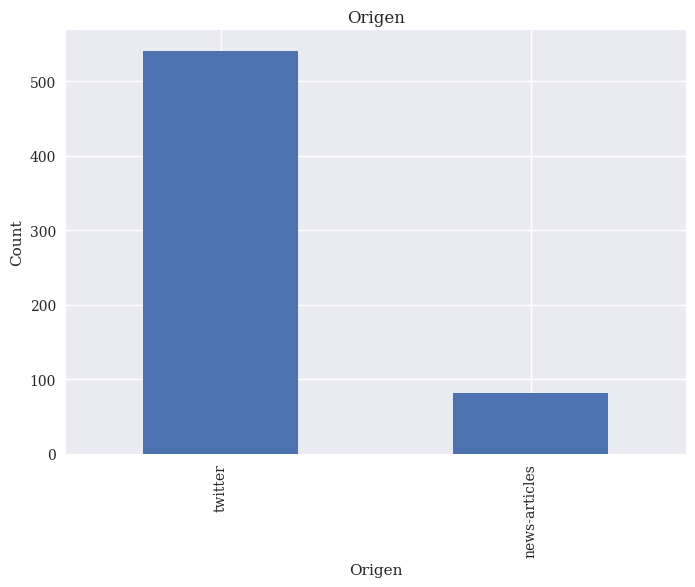

In [ ]:
# Ver de donde proceden los textos
class_distribution = df_errores["origin"].value_counts()
class_distribution.plot(kind='bar')
plt.xlabel('Origen')
plt.ylabel('Count')
plt.title('Origen')
plt.show()

**Esto es muy relevante**, mientras que en conjunto de datos de entrenamiento, la mayoría de textos son de artículos periodísticos, cuando miramos el conjunto de textos en los que el modelo se equivoca, la mayoría son de twitter, lo cual llama mucho la atención.

Esto, probablemente se deba a que en los textos de twitter se ha tenido que eliminar mucha información al eliminar hashtags y usuarios. Además otro factor importante es que la forma en la que se habla en twitter no es la misma que la que se habla en artículos periodísticos, por tanto quizá sería interesante pre-entrenar un modelo con datos tanto de twitter como de periódicos para que aprenda un poco el contexto y la forma de hablar en estos 2 medios.

### SHAP

Una vez seleccionado el mejor modelo según sus métricas de precisión, voy a analizar más en profundidad la capacidad de usar este modelo en un entorno de producción/real. Para ello utilizaré una técnica de interpretabilidad, como lo es [SHAP](https://shap.readthedocs.io/en/latest/index.html). Con esto podremos observar que tokens son más importantes en el modelo para predecir si un texto es tóxico o no.

Por cuestiones de capacidad de cómputo (aplicar SHAP para modelos de lenguaje es extremadamente costoso), solo se obtendrán los valores de shapley de unas pocas frases y no de todo el conjunto de datos.

Para todo el proceso de análisis de SHAP únicamente se usará el mejor modelo obtenido en la fase anterior, es decir el modelo de Beto Emotion.

In [ ]:
beto_emotion = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/model_beto_emotion_finetune_toxic_ES.pkl","rb"))

In [ ]:
model = beto_emotion
model_name = "finiteautomata/beto-emotion-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def getModelOutputs(x):
    a,b = bert_encode(tokenizer, x, 110)
    outputs = model([a,b])
    # print("Outputs:", outputs)
    # scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    # val = sp.special.logit(scores[:,1])
    # print("Val: ", val)
    return outputs

explainer = shap.Explainer(getModelOutputs,tokenizer,output_names=["No tóxico", "Tóxico"])

shap_values = explainer(train_texts[:10])

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or us

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  10%|█         | 1/10 [00:00<?, ?it/s]The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).


  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  30%|███       | 3/10 [00:45<01:09,  9.98s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  40%|████      | 4/10 [01:04<01:22, 13.77s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  50%|█████     | 5/10 [01:23<01:18, 15.77s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  60%|██████    | 6/10 [01:44<01:09, 17.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  80%|████████  | 8/10 [02:06<00:26, 13.31s/it]

  0%|          | 0/90 [00:00<?, ?it/s]

Partition explainer:  90%|█████████ | 9/10 [02:13<00:11, 11.22s/it]

  0%|          | 0/132 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 10/10 [02:20<00:00,  9.91s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 11it [02:39, 15.97s/it]


In [ ]:
df_train[:10][["clean_text","label"]]

clean_text  label
0  Durante su intervención, el vicesecretario de ...      0
1  Nueva manipulación a la mujer de la , dónde se...      1
2  SOLIDARIDAD con los 500 trabajadores de Accion...      1
3  Mañana nuestra candidata a la Xunta  , estará ...      0
4  Porros o educación gratuita.Adoctrinamiento pr...      1
5  Sin embargo, la respuesta iba cargada de un de...      0
6                                 Sí,han leído bien.      0
7                 Las cuatro veces en tierra batida.      0
8          ¿O es que es mejor la situación anterior?      0
9  En 2020 es van contractar ferries ad hoc d’urg...      0

In [ ]:
shap.plots.text(shap_values[0])

Antes de empezar a analizar las frases usando SHAP, hay que tener en cuenta que al estar diferenciado entre frases tóxicas y no tóxicas (o de control) va a ser más fácil encontrarle "un patrón" o una lógica a los valores de SHAP para las frases tóxicas que para las que no lo son.

Como podemos ver con colores rojos para "no toxico" y azul para "toxico" (se invierte si hacemos clickl en "toxico"), no hay ninguna palabra en específico que haga decantar al modelo por una decisión, si no más bien una combinación de estas.

Lo que si resalta a la vista es que idenfitique "Ciudadanos" (partido político) como una palabra que con relativa fuerza (aunque sea baja) hace pensar que el mensaje es tóxico. Esto es cierta manera nos hace ver que el modelo tiene cierto sesgo a la hora de tomar una decisión y se encuentra en el texto con esta palabra. En este contexto esto es muy peligroso ya que de cierta forma al modelo va a considerar como tóxicos mensajes en los que se mencione a este partido. Esto quizá esté ocurriendo porque en el conjunto de datos haya más frases que contengan este término y sean tóxicas que que no lo sean.

2 posibles soluciones serían las siguientes:
* Añadir al conjunto de datos más frases con este término pero que no sean tóxicas
* Eliminar (o sustituir por un token comodín) los términos relacionados con partidos políticos, personas imporantes, etc. Para que no se genere un sesgo.

In [ ]:
shap.plots.text(shap_values[1])

En este mensaje (identificado incorrectamente como no tóxico) podemos ver que las palabrsa que determinan con mayor fuerza que el mensaje no es tóxico son "art" y "14". Probablemente el modelo esté encontrando algún tipo de patrón en el que indentifica que cuando se habla de un artículo de la constituación el mensaje no es tóxico. Para poder arreglar esto se deberían de plantear las siguientes 2 cosas:

* Procesar los números y sustituirlos por $NUMBER$ o algún otro identificador.
* Tener cuidado a la hora de obtener los datos de control (no tóxicos) para evitar estar obteniendo datos con un patrón subyacente que no nos interesa y no permite al modelo generalizar.

In [ ]:
shap.plots.text(shap_values[2])

Este mensaje es identificado correctamente como tóxico. Viendo los valores de Shapley parece ser que el modelo "tiene muy claro" que se trata de un mensaje tóxico. Las palabras que identifica más como tóxicas son "cómplices" y "agradar". Ambas palabras (sobre todo la primera) es común verlas en entorno tóxicos o hablando de algo negativamente.

In [ ]:
shap.plots.text(shap_values[3])

De este mensaje lo más importante a destacar es que el apellido "Alameda" no lo identifica como 1 único token, por lo que para resolver este problema se debería de añadir al diccionario de BERT los apellidos y nombres propios de los cargos políticos más importantes de España (o como he mencionado antes sustituirlos por un comodín para no incurrir en un sesgo).

In [ ]:
shap.plots.text(shap_values[4])

De este mensaje se pueden destacar 2 cosas:
* Hay varias palabras mal tokenizadas (porros, adoctrinamiento, etc)
* Se observa que es claramente un mensaje tóxico, de nuevo se detectan correctamente como relevantes palabras como "progre" o "adoctrinamiento".


In [ ]:
shap.plots.text(shap_values[5])
shap.plots.text(shap_values[6])
shap.plots.text(shap_values[7])
shap.plots.text(shap_values[8])

Estas frases son frases no tóxicas por lo que no hay ningún patrón claro que se pueda observar, como es normal en frases de control.

In [ ]:
shap.plots.text(shap_values[9])

De esta frase lo que más se ha destacar es que está escrita en catalán y por tanto bastantes palabras no son tokenizadas correctamente. Esto nos recuerda que quizá es interesante usar un enfoque que utilice un modelo XLM.

Gracias a este análisis se ha podido ver en que palabras se fija más nuestro modelo y cuales detecta como relavantes. Además así podemos ver si tiene algún tipo de sesgo o problema para intentar paliarlo. Para seguir con el análisis se debería de aplicar SHAP a todo el conjunto de datos y así ver estadísticas globales que aporta SHAP como las palabras más influentes o las más determinantes.

Para este proceso sería muy útil estar junto a un experto de la temática en concreto (sociología o periodismo).